# Credit Card Fraud Detection

In [1]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualisation'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


All the previous exercises made you take a closer look at all the different parts of a neural network: the architecture, the compilation and the fitting.

Let's now work on a real-life dataset that has **a lot of data**!

The data
For this open challenge, you will work with data extracted from credit card transactions. As these are sensitive data, from all the 31 columns, only 3 are known: the rest are data that have been transformed to anonymize them (in fact, they are PCA projections of initial data).

The other three known columns are:

- "TIME": the time elapsed between the transaction and the first transaction in the dataset
- "AMOUNT": the amount of the transaction
- "CLASS" (our target): 0 means that the transaction is valid whereas 1 means that it is a fraud.

❓ **Question** ❓ Start by downloading the data on the Kaggle website here [here](https://www.kaggle.com/mlg-ulb/creditcardfraud) and load data to create `X` and `y`

In [2]:
# Load data
df = pd.read_csv("creditcard.csv")

In [3]:
# Select data
X = df.drop(columns=['Class'],axis=1).values
y = df['Class'].values

## 1. Rebalancing classes

In [4]:
# Let's check class balance
pd.Series(y).value_counts()

0    284315
1       492
dtype: int64

☝️ in this `fraud detection` challenge, the classes are extremely imbalanced:
* 99.8 % of normal transactions
* 0.2 % of fraudulent transactions

We won't be able to detect frauds unless we apply some serious rebalancing strategies!

❓ **Question** ❓
1. **First**, create three separate Train/Val/Test splits from your dataset. It is extremely important to keep validation and testing sets **not rebalanced** so as to evaluate your model in true conditions without data leak. Keep your test set for the very last cell of this notebook only.

&nbsp;
2. **Second**, rebalance you training set (and only this one). You have many choices:

- Simply oversample the minority class randomly using plain numpy functions.
- Or use <a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/">Synthetic Minority Oversampling Technique</a> to generate new datapoints by weighting the existing ones
- In addition, try also <a href="https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/">RandomUnderSampler</a> to downsample a little bit the majority class

In [5]:
# YOUR CODE HERE

In [104]:
# Train test split before any resampling to keep real test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(139554, 30)
(59810, 30)
(85443, 30)


In [8]:
# How many "fraud" sample do I have in each series?
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))

213
108
171


In [9]:
# Sampling strategies
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)

In [10]:
# Pipelining the two strategies
steps =  [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [11]:
# Rebalance the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [12]:
# Reshuffle the resampled data just to be sure
stacked_resampled_data = np.hstack([X_train_resampled, y_train_resampled.reshape(-1,1)])
np.random.shuffle(stacked_resampled_data)

X_train_resampled = stacked_resampled_data[:,:30]
y_train_resampled = stacked_resampled_data[:,-1]

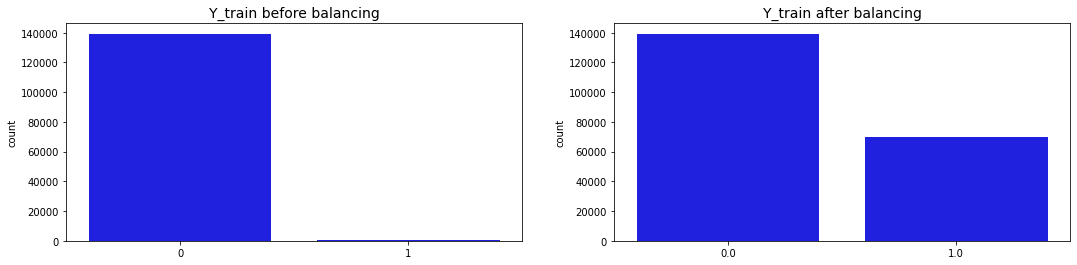

In [13]:
# plotting
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18,4))

''' Before rebalancing classes'''

sns.countplot(y_train, ax=ax[0], color='b')
ax[0].set_title('Y_train before balancing', fontsize=14)

''' After rebalancing classes'''

sns.countplot(y_train_resampled, ax=ax[1], color='b')
ax[1].set_title('Y_train after balancing', fontsize=14);

In [14]:
print(X_train_resampled.shape)
print(X_val.shape)

(209010, 30)
(59810, 30)


## 2. Neural Network iterations

Now that you have rebalanced your classes, try to fit a neural network to optimize your test score. Feel free to use the following hints:

- Normalize your inputs!
    - Use preferably a [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer inside the model to "pipeline" your preprocessing within your model. 
    - Or use sklearn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) outside of your model, applied your `X_train` and `X_val` and `X_test`.
- Make model overfit, then, regularize using
    - Early Stopping criteria 
    - [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers
    - or [`regularizers`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) layers
- 🚨 Think carefully about the metric you want to track and the loss you want to use ?


In [15]:
# YOUR CODE HERE

In [16]:
metrics = [
    keras.metrics.Recall(),
    keras.metrics.Precision(),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

In [63]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.metrics import Recall, Precision

def init_model():
    input_shape = X_train_resampled.shape[1:]
    normalizer = Normalization()
    normalizer.adapt(X_train_resampled)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

### Regularized model

In [65]:
model = init_model()
#model.summary()

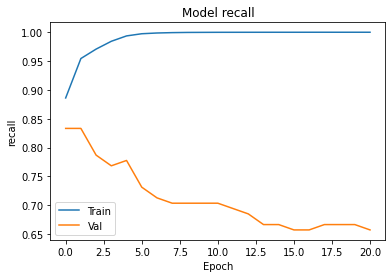

In [59]:
plot_history(history, "recall")

In [69]:
es = EarlyStopping(
    patience=10,
    monitor='val_recall', # We really want to detect fraudulent transactions!
    restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=64, # Large enough to get a decent chance of conatining fraudulent transactions 
                    callbacks=[es], shuffle=True)

Epoch 1/100
3266/3266 [==============================] - 4s 1ms/step - loss: 0.1247 - recall: 0.9087 - precision: 0.9753 - prc: 0.9803 - val_loss: 0.0233 - val_recall: 0.8241 - val_precision: 0.2160 - val_prc: 0.7012
Epoch 2/100
3266/3266 [==============================] - 4s 1ms/step - loss: 0.0963 - recall: 0.9287 - precision: 0.9790 - prc: 0.9871 - val_loss: 0.0231 - val_recall: 0.8333 - val_precision: 0.1957 - val_prc: 0.7029
Epoch 3/100
3266/3266 [==============================] - 4s 1ms/step - loss: 0.0796 - recall: 0.9455 - precision: 0.9786 - prc: 0.9911 - val_loss: 0.0236 - val_recall: 0.8333 - val_precision: 0.1779 - val_prc: 0.7386
Epoch 4/100
3266/3266 [==============================] - 4s 1ms/step - loss: 0.0686 - recall: 0.9542 - precision: 0.9782 - prc: 0.9936 - val_loss: 0.0243 - val_recall: 0.8333 - val_precision: 0.1607 - val_prc: 0.7394
Epoch 5/100
3266/3266 [==============================] - 4s 1ms/step - loss: 0.0593 - recall: 0.9597 - precision: 0.9779 - prc: 0.99

In [57]:
def plot_history(history, metric):
    plt.plot(history.history[f'{metric}'])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

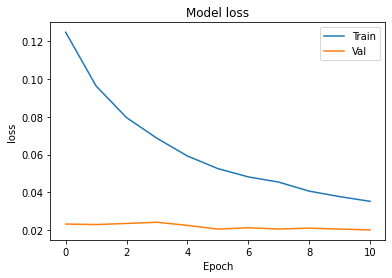

In [70]:
plot_history(history, "loss")

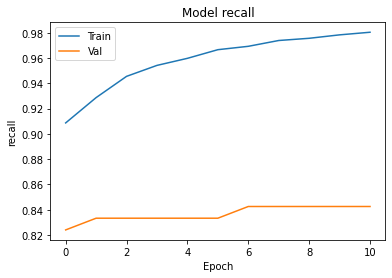

In [71]:
plot_history(history, "recall")

## 3. Score your model on unseen Test set

❓ **Question** ❓: Compute your confusion matrix and classification report on the test set

In [24]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

{'loss': 0.0626240223646164,
 'recall': 0.8011695742607117,
 'precision': 0.7061855792999268,
 'prc': 0.6953915357589722}

In [25]:
y_pred_proba = model.predict(X_test)

In [26]:
y_pred_binary = np.where(y_pred_proba > 0.5, 1, 0 )

### Confusion Matrix

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_binary)
cm

array([[85215,    57],
       [   34,   137]])

Text(0.5, 24.0, 'Predicted label')

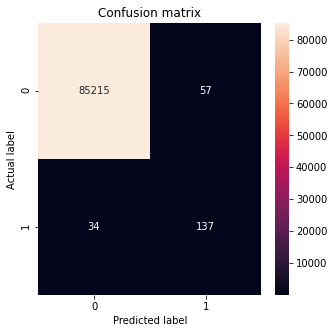

In [28]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85272
           1       0.71      0.80      0.75       171

    accuracy                           1.00     85443
   macro avg       0.85      0.90      0.88     85443
weighted avg       1.00      1.00      1.00     85443



In [30]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

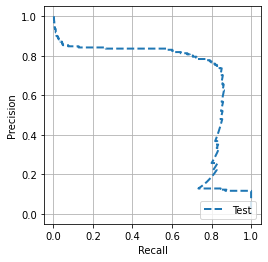

In [31]:
plot_prc("Test", y_test, y_pred_proba, linestyle='--')
plt.legend(loc='lower right')

### 🧪 Test your score

Store below your real test performance on a (`X_test`, `y_test`) representative sample of the original unbalance dataset

In [32]:
precision = 0 # ??
recall = 0 # ??

In [33]:
precision = 0.5
recall = 0.8

In [39]:
from nbresult import ChallengeResult

result = ChallengeResult('solution',
    precision=precision,
    recall=recall,
    fraud_number=len(y_test[y_test == 1]),
    non_fraud_number=len(y_test[y_test == 0]),
)

result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.6, pytest-6.2.3, py-1.10.0, pluggy-0.13.1 -- /Users/brunolajoie/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8
cachedir: .pytest_cache
rootdir: /Users/brunolajoie/code/lewagon/data-solutions/06-Deep-Learning/02-Optimizer-loss-and-fitting/04-Credit-Card-Challenge
plugins: anyio-2.2.0, dash-1.20.0, pylint-0.18.0
collecting ... collected 2 items

tests/test_solution.py::TestSolution::test_is_score_good_enough PASSED   [ 50%]
tests/test_solution.py::TestSolution::test_is_test_set_representative PASSED [100%]

============================== 2 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/solution.pickle

git commit -m 'Completed solution step'

git push origin master


## 🏁 Optional : Read Google's solution for this challenge
Congratulation for finishing all challenges for this session!

To conclude, take some time to read Google's own solution direcly [on Colab here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb). You will discover interesting techniques and best practices
